# Imports.

Libraries used in the project:
 - Pandas & Numpy for data manipulation;
 - Matplotlib & Seaborn for data visualization;
 - XGBClassifier and sklearn models for ML modelling and prediction;
 - Accuracy_score for validation metrics.


In [ ]:
!pip install pyod

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from pyod.models.knn import KNN


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os

# Data Exploration.

First things first, let's explore our dataset and find some informations that could describe it to answer some basic questions that we could come up with.

In [3]:
# Load dataset.
df = pd.read_csv('census.csv')

In [4]:
df

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K


In [5]:
df.shape

(45222, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [7]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [8]:
df.select_dtypes(include='object').nunique()

workclass           7
education_level    16
marital-status      7
occupation         14
relationship        6
race                5
sex                 2
native-country     41
income              2
dtype: int64

## Observations.
 - 45222 rows and 14 columns;
 - 5 Numeric and 9 Object columns;
 - No missing values, but columns 'capital-gain' and 'capital-loss' have ~75% of zero values;
 - Column 'education-num' is a encoded version of 'education_level'.
 - Most categorical columns have low cardinality and probably shouldn't be label encoded. Apart from 'native-country' and 'education_level'.
 - 'sex' and 'race' columns are sensitive data that will probably
 - There are some huge outliers in capital-gain and capital-loss (Both of them have a high variance).
 ------

# Data Visualization.

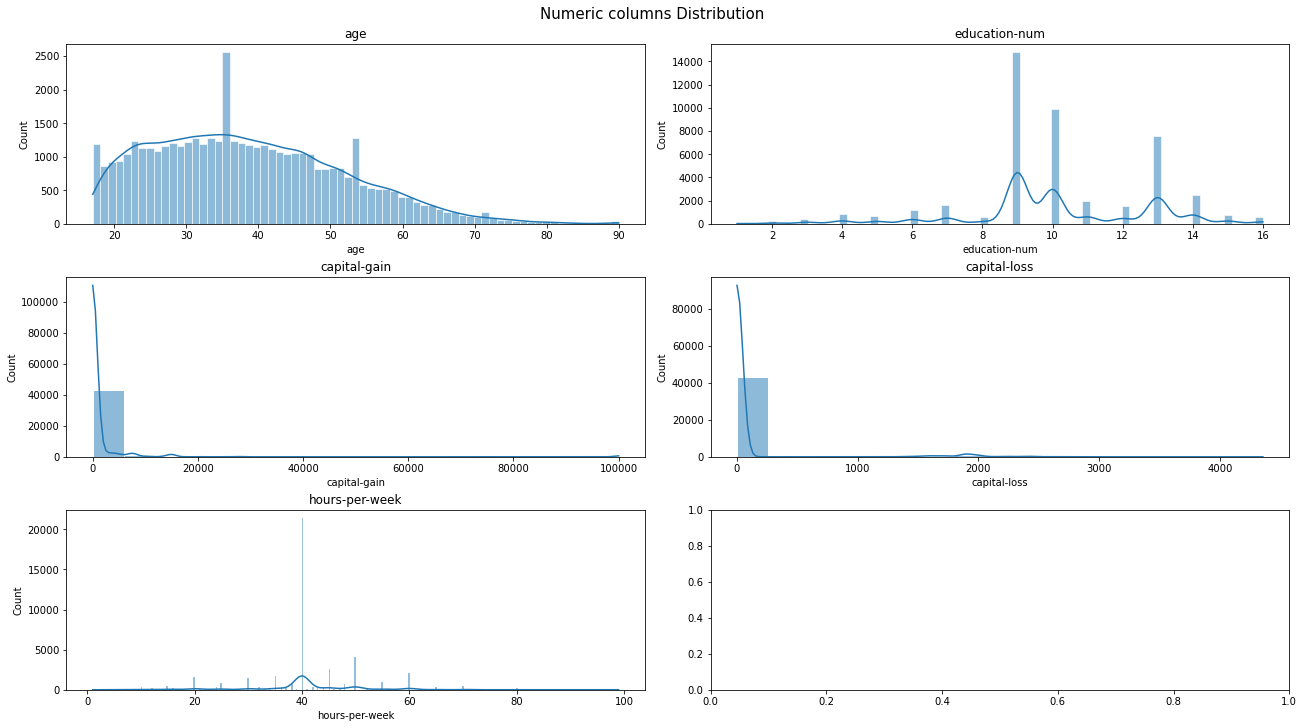

In [9]:
df_numeric = df.select_dtypes(include=[int, float])


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 10), constrained_layout=True)
fig.suptitle('Numeric columns Distribution', fontsize=15)
for col, pos in zip(df_numeric.columns, range(len(df_numeric.columns))):
    sns.histplot(x=df[col],
                ax=ax[pos//2][pos%2],
                kde=True,
                edgecolor="white"
                )
    ax[pos//2][pos%2].set_title(col)
    
plt.show()

In [10]:
df_lencoded = df.copy()
df_object = df.select_dtypes(include='object')

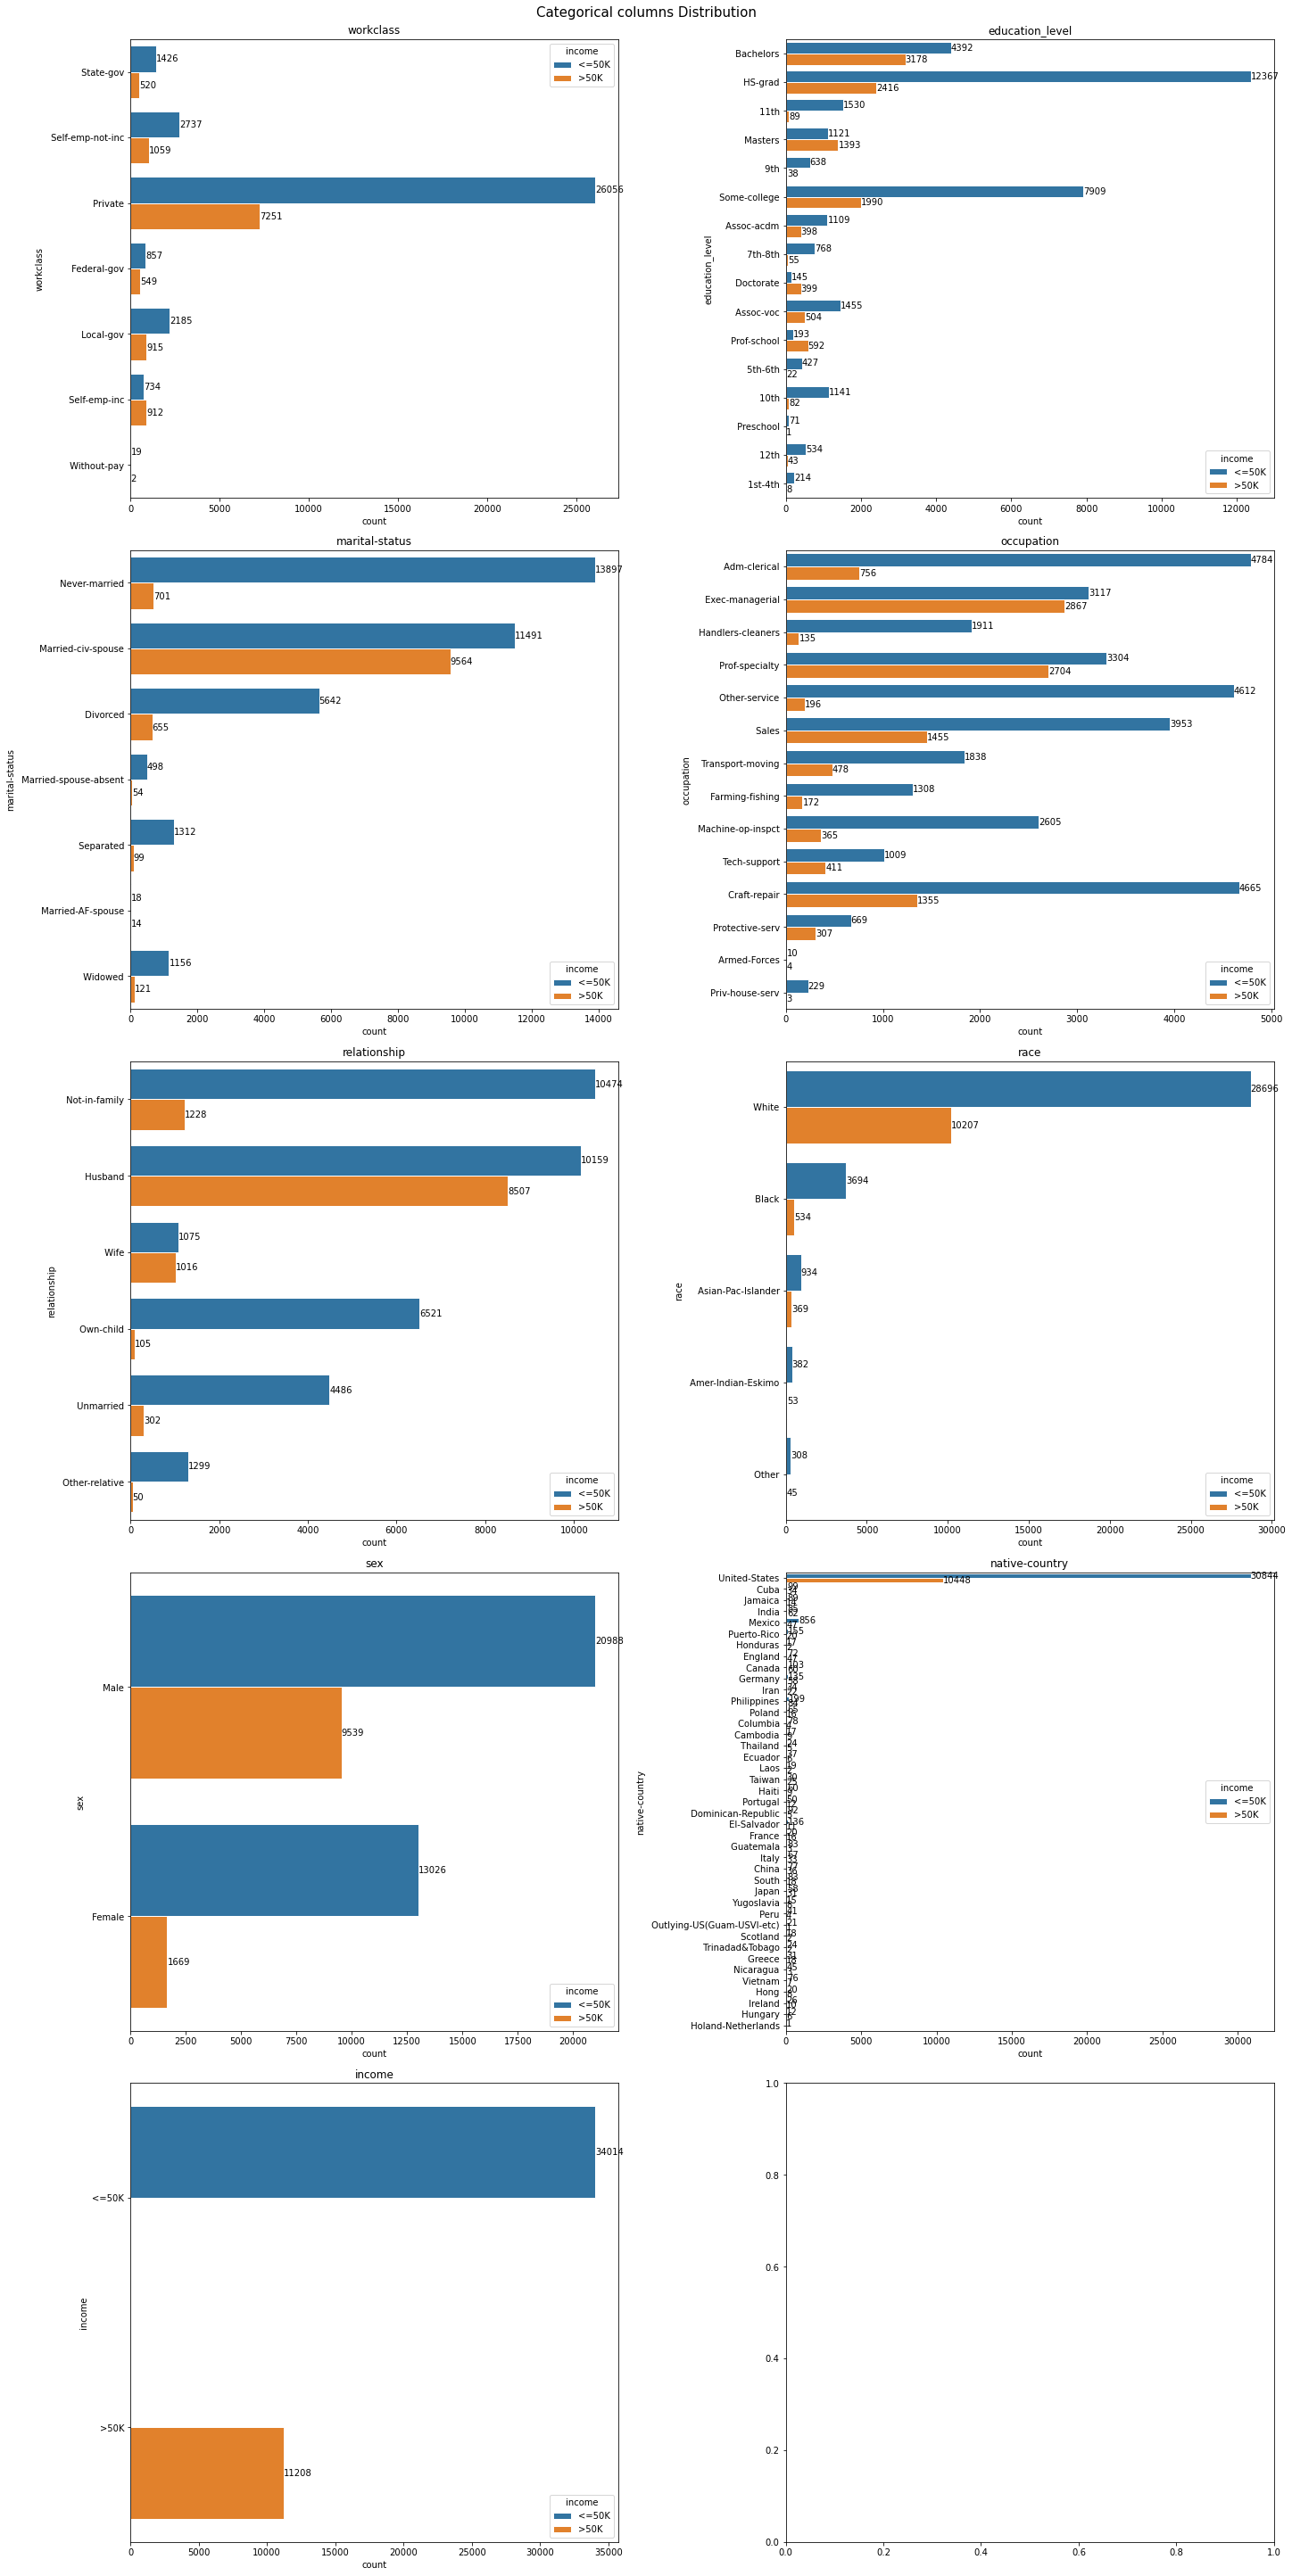

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 40), constrained_layout=True)
fig.suptitle('Categorical columns Distribution', fontsize=15)
for col, pos in zip(df_object.columns, range(len(df_object.columns))):
    sns.countplot(y=df_lencoded[col],
                ax=ax[pos//2][pos%2],
                edgecolor="white",
                hue=df_lencoded['income']
                )
    for container in ax[pos//2][pos%2].containers:
        ax[pos//2][pos%2].bar_label(container)
    ax[pos//2][pos%2].set_title(col)
plt.show()


In [12]:
df_lencoded['income'] = df['income'].map({'<=50K':0, '>50K':1})
df_object = df.select_dtypes(include='object').drop(['income'], axis=1)

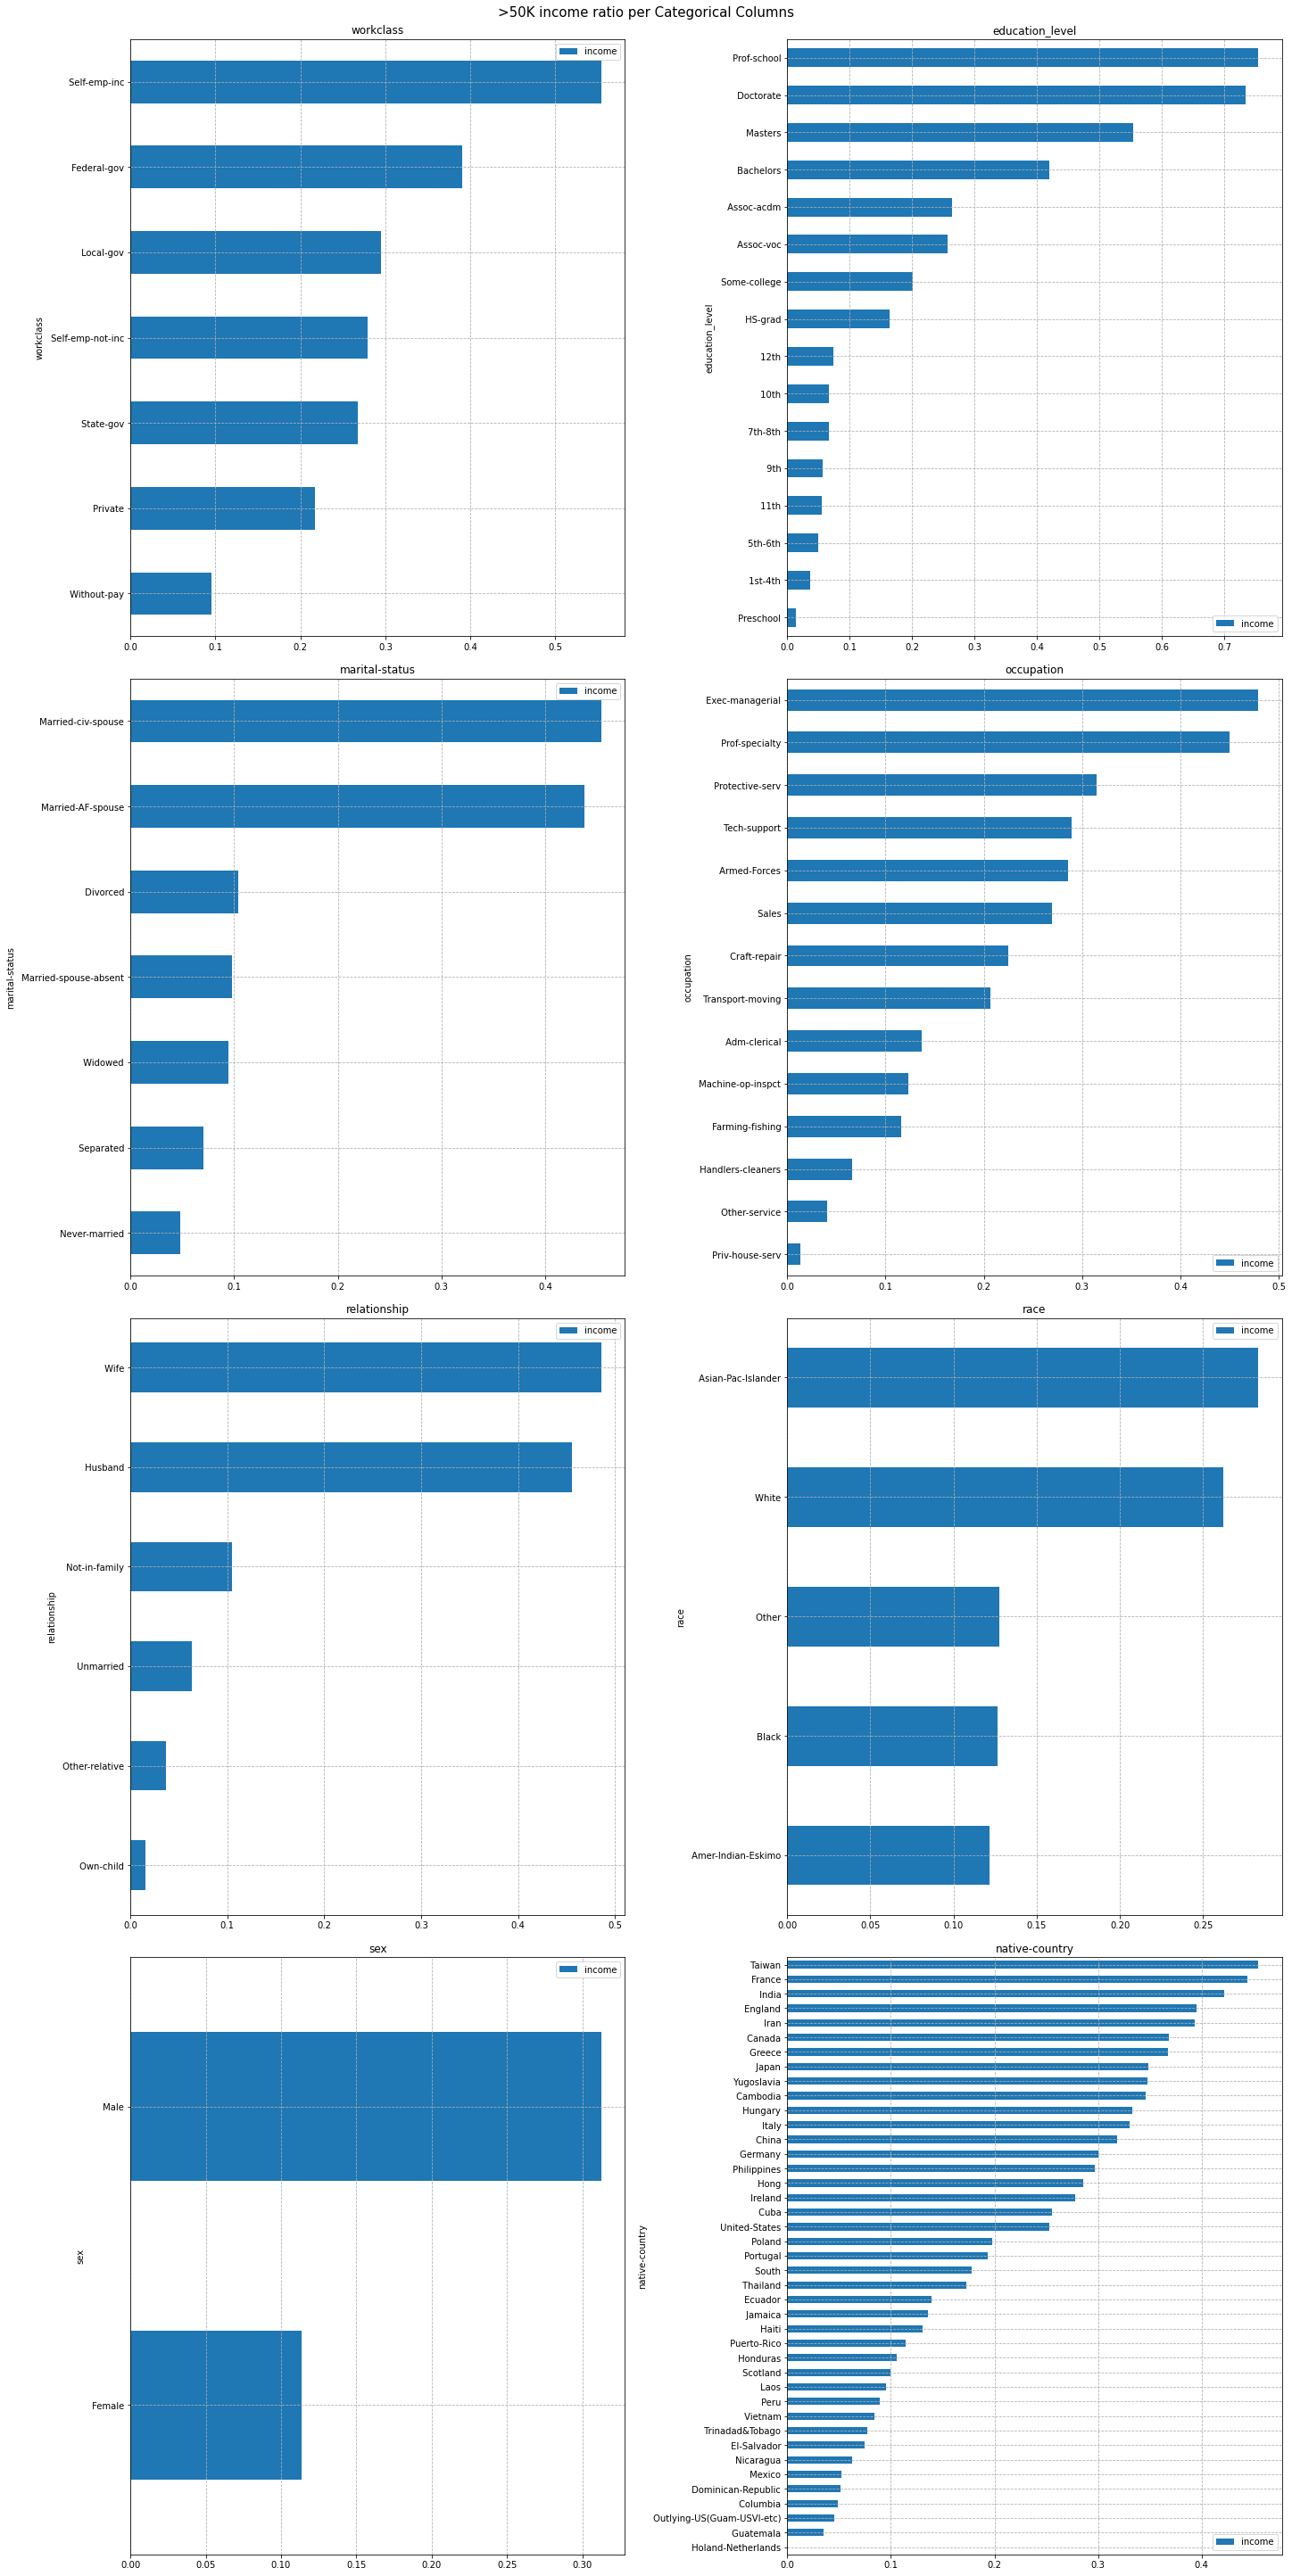

In [13]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 40), constrained_layout=True)
fig.suptitle('>50K income ratio per Categorical Columns', fontsize=15)

for col, pos in zip(df_object.columns, range(len(df_object.columns))):
    df_income_percs = pd.pivot_table(data=df_lencoded, index=col, values='income', aggfunc=np.mean) \
    .sort_values(by='income') \
    .plot(kind='barh', ax=ax[pos//2][pos%2])
    
    ax[pos//2][pos%2].grid(linestyle='--')
    ax[pos//2][pos%2].set_title(col)
plt.show()


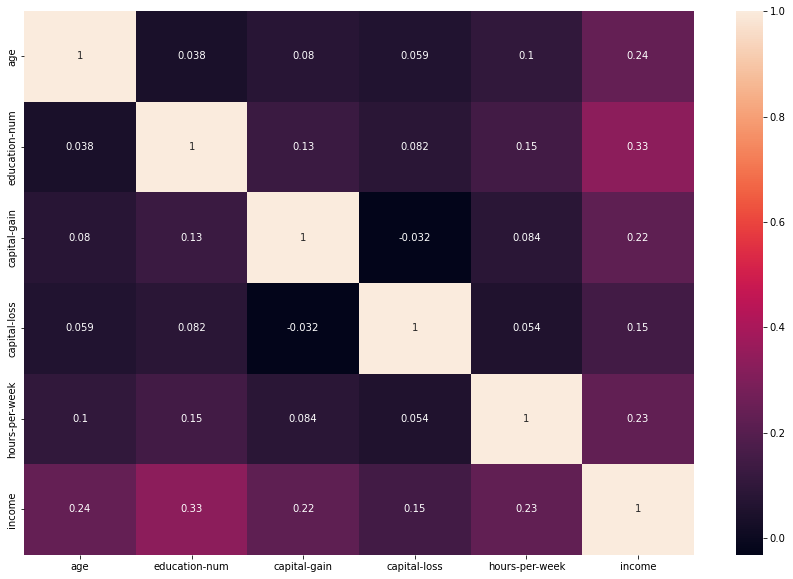

In [14]:
plt.figure(figsize=(15,10))

sns.heatmap(df_lencoded.corr(), annot=True)

plt.show()

In [15]:
outlier_detector = KNN()
outlier_detector.fit(df_numeric)
outliers_index = outlier_detector.labels_
outlier_df = df_numeric.iloc[[i for i in range(len(outliers_index)) if outliers_index[i] == 1], :]

In [16]:
df

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K


In [41]:
display(outlier_df)

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13.0,2174.0,0.0,40.0
1,50,13.0,0.0,0.0,13.0
6,49,5.0,0.0,0.0,16.0
8,31,14.0,14084.0,0.0,50.0
22,43,7.0,0.0,2042.0,40.0
...,...,...,...,...,...
45184,57,10.0,7688.0,0.0,60.0
45185,51,13.0,0.0,1590.0,40.0
45188,32,11.0,5178.0,0.0,60.0
45196,39,13.0,0.0,1669.0,40.0


In [42]:
display(df.describe())
display(outlier_df.describe())
print(outlier_df.shape[0]/df.shape[0])

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


,age,education-num,capital-gain,capital-loss,hours-per-week
count,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000
mean,44.597327,10.471047,6995.055679,645.997327,44.545434
std,15.413481,3.148678,18402.825729,921.020165,16.634978
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,32.000000,9.000000,0.000000,0.000000,40.000000
50%,43.000000,10.000000,2174.000000,0.000000,40.000000
75%,55.000000,13.000000,5178.000000,1669.000000,50.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


0.09928795718897881


## Observations.
 - First things first, we have to take into account that our dataset has an proeminent bias caused by the columns 'race', 'sex' and 'native-country', seeing that most of our observations are from white males native from United States. With that, we need to be careful with the approach that we will choose because of these sensitive data.
 - Men have an ~19% higher income ratio.
 - Even that men have a much higher income ratio, women that are in a relationship as a wife have an slightly higher income ratio;
 - People that aren't in a marriage have ~35% lower income ratio.
 - The three higher income ratio nationality are Taiwan, France and India.
 - Most of the sample works 40 hours per week
 - Considering absolute numbers, the categories that have the most income observations above 50k are:
    <br>- Workclass: 'Private'
    <br>- Education Level: 'Bachelors'
    <br>- Marital Status: 'Married-civ-spouse'
    <br>- Occupation: 'Exec-managerial'
    <br>- Relationship: 'Husband'
    <br>- Race: 'White'
    <br>- Sex: 'Male'
    <br>- Native Country: 'United-States'
 - ~9.92% of the dataset contain values considered outliers.

# Modelling


In [19]:
df.nunique()

age                 74
workclass            7
education_level     16
education-num       16
marital-status       7
occupation          14
relationship         6
race                 5
sex                  2
capital-gain       121
capital-loss        97
hours-per-week      96
native-country      41
income               2
dtype: int64

In [20]:
# sklearn Label Encoder
from sklearn.preprocessing import LabelEncoder

def encode_categorical(dataframe, ohe_cols, le_cols):
    encoder = LabelEncoder()
    for col in ohe_cols:
        dataframe = dataframe.join(pd.get_dummies(dataframe[col]))
        dataframe.drop([col], axis=1, inplace=True)
    for col in le_cols:
        dataframe[col] = encoder.fit_transform(dataframe[col])
    return dataframe
        

ohe_columnss = ['workclass', 'marital-status', 'occupation', 'relationship', 'race']
le_columnss = ['sex', 'native-country', 'income']

# Let's drop 'education_level' as we already have education-num.
df_lencoded = encode_categorical(df.drop(['education_level'], axis=1), ohe_columnss, le_columnss)

In [21]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_lencoded.drop(['income'], axis=1)
y = df_lencoded['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)

X_train, y_train = SMOTE(random_state = 0).fit_resample(X_train, y_train)

In [22]:
df_lencoded.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,native-country,income,Federal-gov,Local-gov,...,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,39,13.0,1,2174.0,0.0,40.0,38,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,50,13.0,1,0.0,0.0,13.0,38,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,9.0,1,0.0,0.0,40.0,38,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,53,7.0,1,0.0,0.0,40.0,38,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13.0,0,0.0,0.0,40.0,4,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [23]:
y_train.value_counts()

0    27186
1    27186
Name: income, dtype: int64

## Now, let's test some models and see the results.

In [24]:
def test_models(X_train, y_train, X_test, y_test):
    models = [
        GaussianNB(),
        XGBClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(),
        SVC(),
    ]

    results = {
        'GaussianNB':0,
        'XGB':0,
        'RandomForest':0,
        'KNeighbor':0,
        'SupportVM':0
    }

    for model, model_name in zip(models, results.keys()):
        model.fit(X_train, y_train)

        results[model_name] = accuracy_score(y_test, model.predict(X_test))
        
    return results

test_models(X_train, y_train, X_test, y_test)

{'GaussianNB': 0.761746821448314,
 'XGB': 0.8567164179104477,
 'RandomForest': 0.8334991708126036,
 'KNeighbor': 0.7861802100608071,
 'SupportVM': 0.7913764510779436}

## Looks like that the XGBClassifier have the best performance.

Let's tweak some hyperparameters and see if we can get some better results.

In [25]:
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        }

model = XGBClassifier(
    learning_rate=0.02,
    n_estimators=1000,
    max_depth=5,
    objective='binary:logistic',
    eval_metric='error',
    seed=0
)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='accuracy', n_jobs=4, verbose=3, random_state=0)
random_search.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0...
                                           max_delta_step=None, max_depth=5,
                                      

In [26]:
accuracy_score(y_test, random_search.best_estimator_.predict(X_test))

0.8758430071862908

In [27]:
random_search.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'gamma': 2,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 0}

In [28]:
# After the Randomized Search, that's the hyperparameters that I could extract better results.

model = random_search.best_estimator_

In [29]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
accuracy_score(y_test, model.predict(X_test))

0.8558319513543394

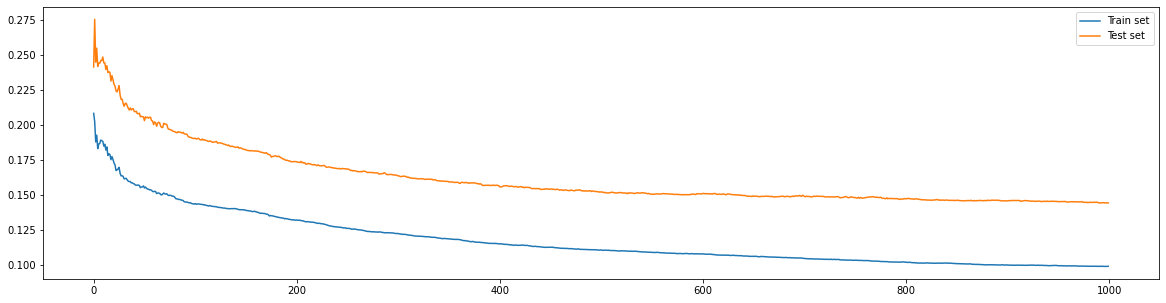

In [31]:
import matplotlib.pyplot as plt

eval_results = model.evals_result()

plt.figure(figsize=(20,5))
                    
plt.plot(eval_results['validation_0']['error'], label='Train set')
plt.plot(eval_results['validation_1']['error'], label='Test set')
                    
plt.legend()

plt.show()

In [32]:
best_estimator_error = min(eval_results['validation_1']['error'])

eval_results['validation_1']['error'].index(best_estimator_error)

992

# Looks like, 680 estimators is the sweet spot for our model.
So, let's change it!

In [33]:
'''model = XGBClassifier(
 objective = 'binary:logistic',
 eval_metric = 'error',
 gamma = 1.5,
 learning_rate = 0.02,
 colsample_bytree = 0.6,
 max_depth = 5,
 max_leaves = 0,
 min_child_weight = 1,
 n_estimators = 1917,
 n_jobs = 0,
 seed = 0
)'''

model = XGBClassifier(
 objective = 'binary:logistic',
 eval_metric = 'error',
 gamma = 0.5,
 learning_rate = 0.02,
 max_depth = 5,
 max_leaves = 0,
 min_child_weight = 1,
 n_estimators = 680,
 n_jobs = 0,
 seed = 0
)
bst = model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=False)

In [34]:
X_test

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,native-country,Federal-gov,Local-gov,Private,...,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
36177,42,14.0,1,0.0,0.0,50.0,38,0,0,0,...,0,0,0,0,0,0,0,0,0,1
36178,43,9.0,1,0.0,0.0,55.0,38,1,0,0,...,0,0,0,0,0,0,0,0,0,1
36179,34,9.0,1,0.0,0.0,40.0,38,0,0,1,...,0,0,0,0,0,0,0,0,0,1
36180,27,14.0,1,0.0,0.0,50.0,38,0,0,1,...,1,0,0,0,0,0,0,0,0,1
36181,47,9.0,1,0.0,0.0,40.0,32,0,0,1,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,13.0,1,0.0,0.0,40.0,38,0,0,1,...,0,0,1,0,0,0,0,0,0,1
45218,39,13.0,0,0.0,0.0,36.0,38,0,0,1,...,1,0,0,0,0,0,0,0,0,1
45219,38,13.0,1,0.0,0.0,50.0,38,0,0,1,...,0,0,0,0,0,0,0,0,0,1
45220,44,13.0,1,5455.0,0.0,40.0,38,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [35]:
accuracy_score(y_test, model.predict(X_test))

0.8505251520176893

## Now, let's test some feature selection.

Let's choose all features that have over 0.001 importance.

In [36]:
fi = pd.Series(bst.feature_importances_, index = X_test.columns).sort_values(ascending=False)
features = fi[fi > 0.005].index

In [37]:
features.shape[0] - X_train.shape[0]

-54336

In [38]:
model_fs = XGBClassifier(
 objective = 'binary:logistic',
 eval_metric = 'error',
 gamma = 0.5,
 learning_rate = 0.02,
 max_depth = 5,
 max_leaves = 0,
 min_child_weight = 1,
 n_estimators = 680,
 n_jobs = 0,
 seed = 0
)
model_fs.fit(X_train[features], y_train, eval_set=[(X_train[features], y_train),(X_test[features], y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=680, n_jobs=0, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [39]:
accuracy_score(y_test, model_fs.predict(X_test[features]))

0.8521835268103924

## Looks like there was some kind of improvement! It wasn't much but let's use only the selected features.

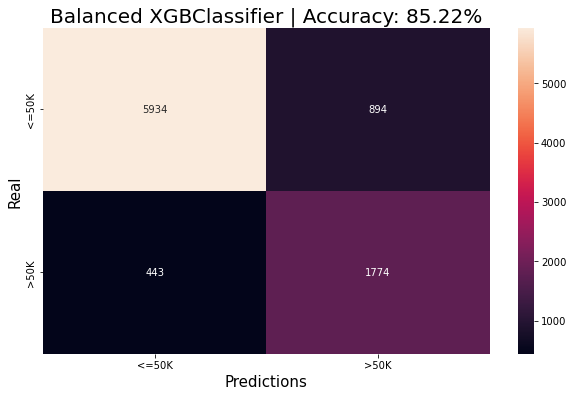

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      6828
           1       0.66      0.80      0.73      2217

    accuracy                           0.85      9045
   macro avg       0.80      0.83      0.81      9045
weighted avg       0.87      0.85      0.86      9045



0.8001804239963916

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

X_test, X_train = X_test[features], X_train[features]

predictions = model_fs.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

plt.figure(figsize=(10,6))

ax = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

ax.set_title(f'Balanced XGBClassifier | Accuracy: {accuracy*100:.2f}%', fontsize=20)
ax.set_xlabel('Predictions', fontsize=15)
ax.set_ylabel('Real', fontsize=15)
ax.set_xticklabels(['<=50K', '>50K'])
ax.set_yticklabels(['<=50K', '>50K'])

plt.show()

print(classification_report(y_test, predictions))
recall_score(y_test, predictions)